In [1]:
import GetOldTweets3 as got
import pandas as pd
import numpy as np
import datetime
import re
import os

# Redefinndo path
os.chdir("C:\\Users\\aliss\\Documents\\Nova IMS\\Cursos\\Text Mining\\Final Project")

### 1 - Capturando tweets

In [ ]:
# Select tweets using the key words

tweetCriteria = got.manager.TweetCriteria().setQuerySearch("#bolsonaropresidente lang:pt")\
                                           .setSince("2019-01-02")\
                                           .setUntil("2019-03-01")\
                                           .setMaxTweets(10)
tweets = got.manager.TweetManager.getTweets(tweetCriteria)

In [ ]:
# Visualizando tweets
for tweet in tweets:
    print(tweet.text, "\n")

In [ ]:
# Save tweets in a dataframe

n = len(tweets)

aux_id = [0] * n
aux_text = [" "] * n
aux_ht = [" "] * n
aux_date = [datetime.date.today()] * n

for i in range(n):
    aux_id[i] = tweets[i].id
    aux_text[i] = tweets[i].text
    aux_ht[i] = tweets[i].hashtags
    aux_date[i] = tweets[i].date
    
df = pd.DataFrame(np.transpose([aux_id, aux_text, aux_ht, aux_date]), columns=["id", "text", " hashtags", "date"])

Para gerar um novo arquivo removendo os tweets já capturados, é necessário carregar o dataset já analisado.

In [ ]:
# Pre processamento para gerar nova lista de tweets

df = pd.concat([df, dataset],axis=0,sort= False)
df = df.drop(df.columns[[4]], axis=1)
df['text'] = df['text'].apply(lambda x: re.sub(r"http\S+", "",x)) 
df = df.drop_duplicates('text')
ind = df['label'].apply(np.isnan)
df = df[ind]

In [ ]:
# Gerando um novo csv
df.to_csv("2019_v2.csv")

### 2 - Limpeza

In [24]:
import spacy
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from unicodedata import normalize
from wordcloud import WordCloud

nlp = spacy.load("pt")

# Use o cmd to install: conda install -c conda-forge spacy
# baixar o modelo em português: python -m spacy download pt

In [3]:
# Retirar tweets de notícias

def remove_news(df):
    df.drop(df[df['text'].str.contains(' via @\w+', regex=True)].index, inplace = True)
    return df

In [4]:
# Função para construção dos bigramas de negação. Ex: não gosto -> nao_gosto

def bigrama_nao(texto):
    p = re.compile(r'(n[ãaâ]o) (\w*)')
    bign = p.findall(texto)
    for i in range(len(bign)):
        texto = re.sub(str(bign[i][0]+' '+bign[i][1]), str(bign[i][0]+'_'+bign[i][1]), texto)

    return texto

#### 2.1 - Pré Processamento
    1 - Remoção de links, pois esses termos não possuem conteúdo semântico;
    2 - Transformando 'n' em nao;
    3 - Remoção de repetição de letras;
    4 - Remoção de citação a outros usuários;
    5 - Conversão de letras maiúsculas em minúsculas, a fim de padronizar o texto;
    6 - Remoção de caracteres não alfabéticos e pontuação;
    7 - Remoção de caracteres numéricos;
    8 - Construindo brigrama não. Ex: não gosto = nao_gosto
    
    * - Trantando as principais abreviações

In [158]:
# Pré processamento

def pre_process(df):
    df['text'] = df['text'].apply(lambda x: re.sub(r"http\S+", "",x)) # 1
    df['text'] = df['text'].apply(lambda x: re.sub(r"pic.twitter\S+", "",x)) # 1
    df['text'] = df['text'].apply(lambda x: re.sub(r'\bn\b', 'nao',x, flags=re.IGNORECASE)) #2
    df['text'] = df['text'].apply(lambda x: re.sub(r'(\w)(\1{2,})', r'\1',x)) # 3
    df['text'] = df['text'].apply(lambda x: re.sub(r'\B@\w+', '',x)) # 4
    df['text'] = df['text'].apply(lambda x: x.lower()) # 5
    df['text'] = df['text'].apply(lambda x: re.sub(r'[\W*]+', ' ',x)) # 6
    df['text'] = df['text'].apply(lambda x: re.sub(r'[0-9]', '',x)) # 7
    df['text'] = df['text'].apply(lambda x: bigrama_nao(x)) # 8
    df['text'] = df['text'].apply(lambda x: re.sub(r'\b  \b', ' ',x)) # 9
    
    # Abreviações básicas
    df['text'] = df['text'].apply(lambda x: re.sub(r'\bpq\b', 'porque',x)) 
    df['text'] = df['text'].apply(lambda x: re.sub(r'\bvc\b', 'você',x)) 
    df['text'] = df['text'].apply(lambda x: re.sub(r'\bvcs\b', 'você',x)) 
    df['text'] = df['text'].apply(lambda x: re.sub(r'\btb\b', 'também',x)) 
    df['text'] = df['text'].apply(lambda x: re.sub(r'\btbm\b', 'também',x)) 
    df['text'] = df['text'].apply(lambda x: re.sub(r'\bpra\b', 'para',x)) 
    df['text'] = df['text'].apply(lambda x: re.sub(r'\bsr\b', 'senhor',x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'\bta\b', 'está',x)) 
    df['text'] = df['text'].apply(lambda x: re.sub(r'\bq\b', 'que',x))

    return df    

In [304]:
# Criando Bigrams que mais informativos de acordo com o modelo testado

def bgram(df):
    df['text'] = df['text'].apply(lambda x: re.sub(r'fake news', 'fake_news',x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'fernando haddad', 'fernando_haddad',x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'dinheiro publico', 'dinheiro_publico',x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'agridem brutalmente', 'agridem_brutalmente',x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'brutalmente estudante', 'brutalmente_estudante',x))
    return df


In [6]:
# Palavras chaves que foram usandos na selação dos tweetrs
tweet_key = {'jair', 'presidente','bolsonaro','brasil','candidato'}

In [201]:
# Adiconando novos stopwords

new_sw = ['o','a','e','dele', '',' ']
for word in new_sw:
    nlp.Defaults.stop_words.add(word)
    
stopwords_set = nlp.Defaults.stop_words

#### 2.2 - Pré Processamento - Unigramas
    1 - É necessário tokenizar o corpus para aplicar os próximos processos de limpeza;
    2 - Lematizando; 
    3 - Retirando as palavras chaves usadas na busca dos tweets;
    4 - O conjunto de stop words no pacote de portugês está com acentuação e por isso é preciso ter alguns cuidados na hora de fazer o pre processamento, pois o stop word deve ser um dos últimos procedimentos;
    5 - Substituição de caracteres acentuados pelos correspondentes sem acentuação;

In [236]:
# Segunda etapa de limpeza

def pre_process2(df):
    df.loc[:,'text_process'] = df["text"].apply(lambda row: nlp(row)) # 1
    df.loc[:,'text_process'] = df["text_process"].apply(lambda row: [word.lemma_ for word in row]) # 2
    df.loc[:,'text_process'] = df["text_process"].apply(lambda row: [word for word in row if word not in tweet_key]) # 3
    df.loc[:,'text_process'] = df["text_process"].apply(lambda row: [word for word in row if word not in stopwords_set]) # 4
    df.loc[:,'text_process'] = df["text_process"].apply(lambda row: [normalize('NFKD', word).encode('ASCII', 'ignore').decode('ASCII') for word in row]) # 5
    return df

#### 2.3 - Pré Processamento - Bigramas
    1 - Criando bigramas;
    2 - Retirando as palavras chaves usadas na busca dos tweets;
    3 - O conjunto de stop words no pacote de portugês está com acentuação e por isso é preciso ter alguns cuidados na hora de fazer o pre processamento, pois o stop word deve ser um dos últimos procedimentos;
    4 - Substituição de caracteres acentuados pelos correspondentes sem acentuação;

In [9]:
# Criando Bigramas

def bigramReturner(df):
    df.loc[:,'bigram'] = df["text"].apply(lambda row: [' '.join(word) for word in nltk.bigrams(row.split()) \
                                                       if word[0] not in tweet_key and word[1] not in tweet_key \
                                                      and word[0] not in stopwords_set and word[1] not in stopwords_set] )
    df.loc[:,'bigram'] = df["bigram"].apply(lambda row: [normalize('NFKD', word).encode('ASCII', 'ignore').decode('ASCII') for word in row])
    return df

### 3 - Organizando os dados

In [323]:
# Processsamento dos arquivos

df1 = pd.read_csv('2019_02_05-2019_03_05_Label.csv')
df2 = pd.read_csv('2019_01_05-2019_02_05_label.csv')
df3 = pd.read_csv('2018_09_10-2018_10_10_label.csv')

df1 = df1.drop(df1.columns[[5]], axis=1)
df1.iloc[322,5] = -1
df1.label = pd.to_numeric(df1.label, errors = 'coerce')
df1.label = df1.label.astype('int64')
df2 = df2.rename(columns={'sent': 'label'})
df2 = df2.drop(df2.columns[[6]], axis=1)
df3.iloc[452,5] = 1
df3.label = df3.label.astype('int64')
dataset = pd.concat([df1,df2,df3],axis=0)
dataset['text'].dropna(inplace=True)
dataset.text = dataset.text.astype('str')
dataset.reset_index(inplace= True)
dataset = dataset.drop(dataset.columns[[0,1]], axis=1)

In [324]:
#Removendo tweets de notícias que não agregam valor.
remove_news(dataset)

,id,text,hashtags,date,label
0,1102720364990394368,"@VEJA , qual o seu interesse em saber sobre o ...",NaN,2019-03-04 23:59:57+00:00,0
1,1102720181044944897,Parabéns ao nosso presidente Bolsonaro https:/...,NaN,2019-03-04 23:59:13+00:00,1
2,1102720130797264896,Eu apoio a volta das lives do Bolsonaro. Até s...,NaN,2019-03-04 23:59:01+00:00,1
3,1102720110123515904,Foi pra isso que votei no nosso presidente Bol...,NaN,2019-03-04 23:58:56+00:00,1
4,1102720088887697410,Eu apoio a volta das lives do Bolsonaro. Até s...,NaN,2019-03-04 23:58:51+00:00,1
5,1102720030108733441,Bolsonaro é um presidente medíocre.,NaN,2019-03-04 23:58:37+00:00,-1
6,1102720029483778049,Você é a favor de uma investigação profunda no...,#LavaJatoNoMec,2019-03-04 23:58:37+00:00,1
7,1102719857081110528,Foliões por todo o Brasil se manifestaram cont...,NaN,2019-03-04 23:57:56+00:00,-1
8,1102719816165703682,"Parabéns Presidente Bolsonaro, em todo mundo o...",NaN,2019-03-04 23:57:46+00:00,1
9,1102719561961484288,MUITAS BÊNÇÃOS PARA O NOSSO PRESIDENTE JAIR ME...,NaN,2019-03-04 23:56:45+00:00,1


In [325]:
# Analisando o data frame

total_base = sum(dataset['label'].value_counts())
print("Percentual Negativos: {0:.2f}%".format(100*sum(dataset[dataset['label'] == -1]['label'].value_counts())/total_base))
print("Percentual Positivos: {0:.2f}%".format(100*sum(dataset[dataset['label'] == 1]['label'].value_counts())/total_base))
print("Percentual Neutro: {0:.2f}%".format(100*sum(dataset[dataset['label'] == 0]['label'].value_counts())/total_base))

Percentual Negativos: 20.41%
Percentual Positivos: 41.40%
Percentual Neutro: 38.19%


In [326]:
# Aplicando as funções de pre processamento

pre_process(dataset)
bgram(dataset)
pre_process2(dataset)
bigramReturner(dataset)

,id,text,hashtags,date,label,text_process,bigram
0,1102720364990394368,qual o seu interesse em saber sobre o carnava...,NaN,2019-03-04 23:59:57+00:00,0,"[interessar, sobrar, carnaval, flavio, falir, ...","[mandou matar, dinheiro publico, preso babaca]"
1,1102720181044944897,parabéns ao nosso presidente bolsonaro,NaN,2019-03-04 23:59:13+00:00,1,[parabem],[]
2,1102720130797264896,eu apoio a volta das lives do bolsonaro até su...,NaN,2019-03-04 23:59:01+00:00,1,"[apoiar, voltar, lives, sugerir, excelente, se...","[excelentissimo senhor, economia paulo, paulo ..."
3,1102720110123515904,foi para isso que votei no nosso presidente bo...,NaN,2019-03-04 23:58:56+00:00,1,"[parir, votar, parir, acabar, roubalheira, esq...","[esquerda secou, trabalhar k]"
4,1102720088887697410,eu apoio a volta das lives do bolsonaro até su...,NaN,2019-03-04 23:58:51+00:00,1,"[apoiar, voltar, lives, sugerir, excelente, se...","[excelentissimo senhor, economia paulo, paulo ..."
5,1102720030108733441,bolsonaro é um presidente medíocre,NaN,2019-03-04 23:58:37+00:00,-1,[mediocre],[]
6,1102720029483778049,você é a favor de uma investigação profunda no...,#LavaJatoNoMec,2019-03-04 23:58:37+00:00,1,"[umar, investigacao, profundo, ministerio, edu...","[investigacao profunda, vamos subir, tag lavaj..."
7,1102719857081110528,foliões por todo o brasil se manifestaram cont...,NaN,2019-03-04 23:57:56+00:00,-1,"[foliao, manifestar, catarse, vir]",[]
8,1102719816165703682,parabéns presidente bolsonaro em todo mundo o ...,NaN,2019-03-04 23:57:46+00:00,1,"[parabem, mundo, escoamento, trilho, lobby, ac...",[lobby acabaram]
9,1102719561961484288,muitas bênçãos para o nosso presidente jair me...,NaN,2019-03-04 23:56:45+00:00,1,"[bencao, parir, messias]",[muitas bencaos]


In [327]:
# Criando uma nova coluna: Unigrama + Bigrama

bigram = dataset["bigram"].tolist()
unigram = dataset["text_process"].tolist()
uni_bi=[]
for l in range(len(bigram)):  
    uni_bi.append(bigram[l] + unigram[l])
    
dataset.loc[:,'uni_bigram'] = uni_bi

In [328]:
dataset.head()

,id,text,hashtags,date,label,text_process,bigram,uni_bigram
0,1102720364990394368,qual o seu interesse em saber sobre o carnava...,NaN,2019-03-04 23:59:57+00:00,0,"[interessar, sobrar, carnaval, flavio, falir, ...","[mandou matar, dinheiro publico, preso babaca]","[mandou matar, dinheiro publico, preso babaca,..."
1,1102720181044944897,parabéns ao nosso presidente bolsonaro,NaN,2019-03-04 23:59:13+00:00,1,[parabem],[],[parabem]
2,1102720130797264896,eu apoio a volta das lives do bolsonaro até su...,NaN,2019-03-04 23:59:01+00:00,1,"[apoiar, voltar, lives, sugerir, excelente, se...","[excelentissimo senhor, economia paulo, paulo ...","[excelentissimo senhor, economia paulo, paulo ..."
3,1102720110123515904,foi para isso que votei no nosso presidente bo...,NaN,2019-03-04 23:58:56+00:00,1,"[parir, votar, parir, acabar, roubalheira, esq...","[esquerda secou, trabalhar k]","[esquerda secou, trabalhar k, parir, votar, pa..."
4,1102720088887697410,eu apoio a volta das lives do bolsonaro até su...,NaN,2019-03-04 23:58:51+00:00,1,"[apoiar, voltar, lives, sugerir, excelente, se...","[excelentissimo senhor, economia paulo, paulo ...","[excelentissimo senhor, economia paulo, paulo ..."


### 4 - Análise exploratória

In [329]:
# Função para criar núvem de palavras

stopwords_set = nlp.Defaults.stop_words

def print_wordcloud(data, bg_color):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=stopwords_set,
                  background_color=bg_color,
                  width=3000,
                  height=2000
                ).generate(words)
    plt.figure(1, figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [330]:
# Funções para bag of words

def get_all_words(tweets):
    all_words = []
    for (words) in tweets.tolist():
        all_words.extend(words)
    return all_words

def get_bag_of_words(all_words):
    return nltk.FreqDist(all_words)

In [331]:
all_words = get_all_words(dataset["text_process"]) # Escolha a coluna a ser analisada
bag_of_words = get_bag_of_words(all_words)
word_features = bag_of_words.keys()

In [332]:
# Analisando a frequencia do dicionário
bag_of_words.most_common(30)

[('candidatar', 469),
 ('parir', 406),
 ('umar', 181),
 ('d', 158),
 ('comer', 144),
 ('votar', 140),
 ('pelar', 127),
 ('apoiar', 121),
 ('governar', 119),
 ('querer', 118),
 ('pt', 112),
 ('suar', 108),
 ('deus', 93),
 ('senhor', 84),
 ('falar', 80),
 ('n', 80),
 ('ficar', 79),
 ('outro', 73),
 ('educacao', 67),
 ('bolsonaropresidente', 65),
 ('falir', 63),
 ('sobrar', 62),
 ('ano', 60),
 ('brasileiro', 59),
 ('pessoa', 58),
 ('pais', 55),
 ('nao_e', 55),
 ('haddad', 55),
 ('lula', 54),
 ('dever', 54)]

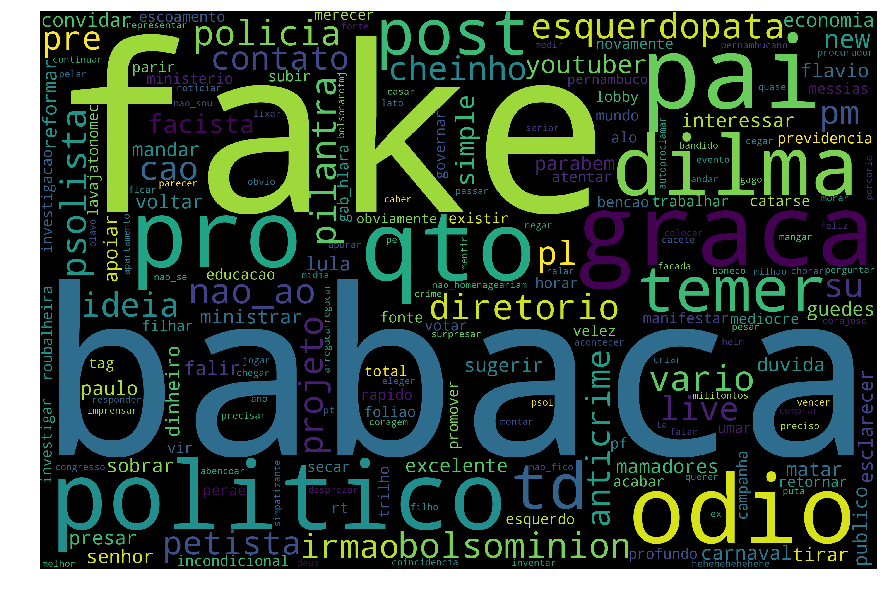

In [151]:
# Núvem de palavras do dicionário
print_wordcloud(bag_of_words, 'black')

### 5- Análise de Sentimento

#### 5.1 - Naive Bayes - NLTK

In [294]:
train_test= []

for index, row in dataset.iterrows():
    train_test.append((dataset["bigram"][index] , row['label']))

In [295]:
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

In [296]:
featuresets = [(find_features(rev), category) for (rev, category) in train_test]

In [297]:
train, test = train_test_split(featuresets, test_size=0.3)

In [298]:
classifier = nltk.NaiveBayesClassifier.train(train)

In [299]:
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, test))*100)

Classifier accuracy percent: 50.85158150851582


In [302]:
classifier.show_most_informative_features(20)

Most Informative Features
         fernando haddad = True                0 : 1      =      3.9 : 1.0
        dinheiro publico = True                1 : 0      =      3.5 : 1.0
     agridem brutalmente = True               -1 : 0      =      3.2 : 1.0
   brutalmente estudante = True               -1 : 0      =      3.2 : 1.0
       tomar antibiotico = True                0 : 1      =      3.2 : 1.0
         ministro sergio = True                0 : 1      =      3.2 : 1.0
   excelentissimo senhor = True                1 : 0      =      2.9 : 1.0
            deus abencoe = True                1 : 0      =      2.9 : 1.0
               fake news = True               -1 : 0      =      2.5 : 1.0
              pt nao_fez = True               -1 : 1      =      2.0 : 1.0
           resposta veio = True               -1 : 1      =      2.0 : 1.0
              ana amelia = True               -1 : 1      =      2.0 : 1.0
       teria substituido = True               -1 : 1      =      2.0 : 1.0

#### 5.2 - Naive Bayes - Sklearn

In [311]:
from sklearn import naive_bayes
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix 

In [333]:
# Split the model into Train and Test Data set
dataset.loc[:,'text_process'] = dataset["text_process"].apply(lambda row: str(row))
Train_X, Test_X, Train_Y, Test_Y = train_test_split(dataset['text_process'],dataset['label'],test_size=0.3)

In [334]:
# Vectorize the words by using TF-IDF Vectorizer - This is done to find how important a word in document is in comaprison to the corpus
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(dataset['text_process'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [335]:
# Aplicando TF-IDF

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [336]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [337]:
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

In [338]:
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score: {0:.2f}%".format(accuracy_score(predictions_NB, Test_Y)*100))

Naive Bayes Accuracy Score: 57.18%


In [339]:
result = cross_val_predict(Naive,Train_X_Tfidf,Train_Y, cv=10)
classes = Train_Y.values
#accuracy_score(result, classes)
print("Cross Validation Accuracy Score: {0:.2f}%".format(accuracy_score(result, classes)*100))

Cross Validation Accuracy Score: 54.60%


In [340]:
sentimentos = [1, -1, 0]
print(metrics.classification_report(classes, result, sentimentos))

              precision    recall  f1-score   support

           1       0.54      0.74      0.63       386
          -1       0.60      0.02      0.03       199
           0       0.55      0.63      0.59       371

   micro avg       0.55      0.55      0.55       956
   macro avg       0.56      0.46      0.41       956
weighted avg       0.56      0.55      0.49       956



In [43]:
# Plot Consfusion matrix

from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[  4   0   0]
 [ 39  92  41]
 [ 37  59 139]]


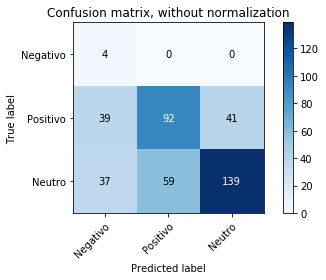

In [341]:
# Plot non-normalized confusion matrix
class_names = np.array(['Positivo','Neutro','Negativo'])
# Plot non-normalized confusion matrix
plot_confusion_matrix(predictions_NB, Test_Y, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

* https://scikit-learn.org/stable/modules/model_evaluation.html

##### Dúvidas:
* O que fazer com tweets de notícia?
* Como substituir emoticons puxando de uma dicionário ou dataframe?
* Como substituir abreviações puxando de uma dicionário ou dataframe?
* Como indentificar tweets não relacionados ao assunto?
* Base desbalanceada, fazer o tratamento